# Kalman Theory


## Multivariate notations

variables: 
* $\mathbf x$, $\mathbf P$: the state and covariance
* $\mathbf F$,  $\mathbf Q$: the process model and noise covariance
* $\mathbf{B,u}$: Optionally, the control input and function
* $\mathbf z$, the measurement mean, and $\mathbf R$, the measurement covariance.
* $\mathbf H$ measurment function
$$
* 

\begin{aligned}
\text{Predict Step}\\
\mathbf{\bar x} &= \mathbf{F x} + \mathbf{B u} \\
\mathbf{\bar P} &= \mathbf{FP{F}}^\mathsf T + \mathbf Q \\
\\
\text{Update Step}\\
\textbf{S} &= \mathbf{H\bar PH}^\mathsf T + \mathbf R \\
\mathbf K &= \mathbf{\bar PH}^\mathsf T \mathbf{S}^{-1} \\
\textbf{y} &= \mathbf z - \mathbf{H \bar x} \\
\mathbf x &=\mathbf{\bar x} +\mathbf{K\textbf{y}} \\
\mathbf P &= (\mathbf{I}-\mathbf{KH})\mathbf{\bar P}
\end{aligned}

$$

as seen in litrature:

 $$
\begin{aligned}
\hat{\mathbf x}_{k\mid k-1} &= \mathbf F_k\hat{\mathbf x}_{k-1\mid k-1} + \mathbf B_k \mathbf u_k  \\
\mathbf P_{k\mid k-1} &=  \mathbf F_k \mathbf P_{k-1\mid k-1} \mathbf F_k^\mathsf T + \mathbf Q_k \\        	
\tilde{\mathbf y}_k &= \mathbf z_k - \mathbf H_k\hat{\mathbf x}_{k\mid k-1}\\
\mathbf{S}_k &= \mathbf H_k \mathbf P_{k\mid k-1} \mathbf H_k^\mathsf T + \mathbf R_k \\
\mathbf K_k &= \mathbf P_{k\mid k-1}\mathbf H_k^\mathsf T \mathbf{S}_k^{-1}\\
\hat{\mathbf x}_{k\mid k} &= \hat{\mathbf x}_{k\mid k-1} + \mathbf K_k\tilde{\mathbf y}_k\\
\mathbf P_{k|k} &= (I - \mathbf K_k \mathbf H_k) \mathbf P_{k|k-1}
\\\end{aligned}
$$

# Kalman implementation 
## Auxiliary functions


In [1]:
from numpy.random import randn
import math
import numpy as np
from filterpy.common import Q_discrete_white_noise
from filterpy.kalman import KalmanFilter
from filterpy.common import Saver
from kf_book.mkf_internal import plot_track
from dataclasses import dataclass
import matplotlib.pyplot as plt

def compute_dog_data(z_var, process_var, count=1, dt=1.):
    "returns track, measurements 1D ndarrays"
    x, vel = 0., 1.
    z_std = math.sqrt(z_var) 
    p_std = math.sqrt(process_var)
    xs, zs = [], []
    for _ in range(count):
        v = vel + (randn() * p_std)
        x += v*dt        
        xs.append(x)
        zs.append(x + randn() * z_std)        
    return np.array(xs), np.array(zs)


@dataclass
class KalmanParams:
    description: str
    R_var: float
    Q_var: float
    F_dynamic: callable  # Function to compute F
    F_static: np.ndarray 
    R: np.ndarray
    Q: np.ndarray
    H: np.ndarray
    x: np.ndarray
    P: np.ndarray

    def F(self):
        return self.F_dynamic(self,gamma_tot)
    
    def __repr__(self):
        max_key_len = max(len(key) for key in vars(self).keys())
        lines = []
    
        for key, value in vars(self).items():
            key_str = f"{key.ljust(max_key_len)} : "
            value_str = str(value)
    
            # If the value spans multiple lines, indent all but the first line
            if '\n' in value_str:
                value_lines = value_str.split('\n')
                indented_value = '\n'.join(' ' * (max_key_len + 3) + line for line in value_lines)
                lines.append(f"{key_str}\n{indented_value}")
            else:
                lines.append(f"{key_str}{value_str}")
        
        return '\n'.join(lines)

            
    

## Dog-walking parameters - example

In [2]:

# model data
dt = 1.
R_var = 10
Q_var = 0.01


F = np.array([[1, dt],
             [0,  1]])

R = np.array([[R_var]])
Q = Q_discrete_white_noise(dim=2, dt=dt, var=Q_var)
H = np.array([[1., 0.]])

# initial data 
x = np.array([[10.0, 4.5]]).T
P = np.diag([500, 49])

params_dog = KalmanParams(R_var=R_var, Q_var=Q_var, F_static=F,F_dynamic=None, R=R, Q=Q, H=H, x=x, P=P,description="Example params for a walking dog")
print(params_dog)

#creating data
count_dog = 50
track_dog, zs_dog = compute_dog_data(params_dog.R_var, params_dog.Q_var, count_dog,dt=1)

description : Example params for a walking dog
R_var       : 10
Q_var       : 0.01
F_dynamic   : None
F_static    : 
              [[1. 1.]
               [0. 1.]]
R           : [[10]]
Q           : 
              [[0.0025 0.005 ]
               [0.005  0.01  ]]
H           : [[1. 0.]]
x           : 
              [[10. ]
               [ 4.5]]
P           : 
              [[500   0]
               [  0  49]]


## fitterPy implementaion

In [3]:

def pos_vel_filter(x, P, R, Q,F):
    """ Returns a KalmanFilter which implements a
    constant velocity model for a state [x dx].T
    """
    
    kf = KalmanFilter(dim_x=2, dim_z=1)
    kf.x = np.array([x[0], x[1]]) # location and velocity
    kf.F = F
    kf.H = np.array([[1., 0]])    # Measurement function
    kf.R *= R                     # measurement uncertainty
    if np.isscalar(P):
        kf.P *= P                 # covariance matrix 
    else:
        kf.P[:] = P               # [:] makes deep copy
    if np.isscalar(Q):
        kf.Q = Q_discrete_white_noise(dim=2, dt=1, var=Q) #should only called on dog example
    else:
        kf.Q[:] = Q
    return kf


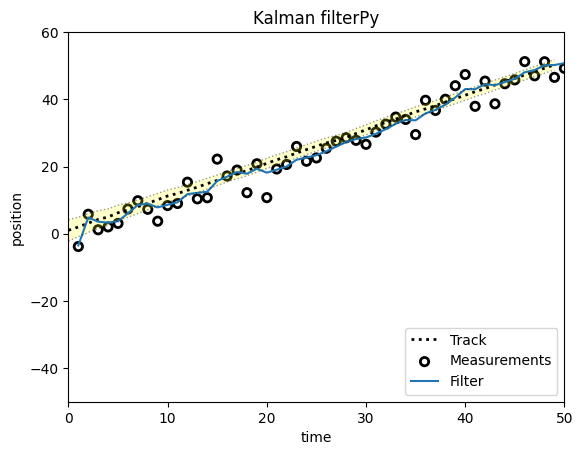

In [4]:

def kalman_filterPy(kalman_params,zs):
    kf = pos_vel_filter(x=kalman_params.x, R=kalman_params.R, P=kalman_params.P, Q=kalman_params.Q, F=kalman_params.F_static) 
    s = Saver(kf)
    for z in zs:
        kf.predict()
        kf.update(z)
        s.save()  # save the current state
    
    # print(s.keys)
    s.to_array()
    return s

s = kalman_filterPy(params_dog,zs_dog)
plot_track(s.x[:, 0], track_dog, s.z, s.P,plot_P=False,title="Kalman filterPy")

## Matrices implemenation

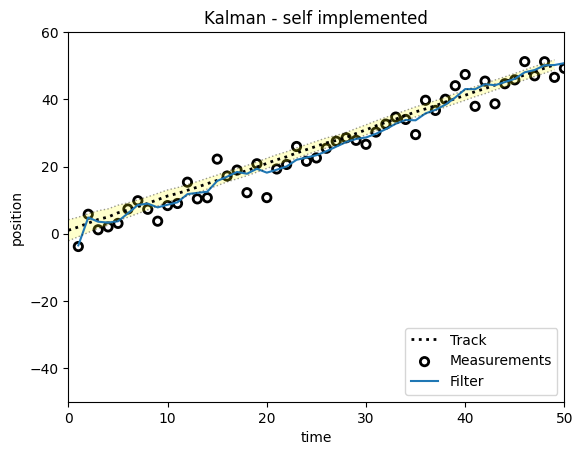

In [5]:


from scipy.linalg import inv

def matrices_implementation(kalman_params,zs):
    x = kalman_params.x
    F = kalman_params.F_static
    
    H = kalman_params.H
    R = kalman_params.R
    P = kalman_params.P
    Q = kalman_params.Q
    
    
    xs, Ps = [], []
    for z in zs:
        # predict
        x = F @ x
        P = F @ P @ F.T + Q
        
        #update
        S = H @ P @ H.T + R
        K = P @ H.T @ inv(S)
        y = z - H @ x
        x += K @ y
        P = P - K @ H @ P
        # P = (np.eye(2) - K @ H) @ P @ (np.eye(2)- K @ H.T) + K @ R @ K ## unclear K dimentions 
        
        xs.append(x)
        Ps.append(P)
    
    xs, Ps = np.array(xs), np.array(Ps)
    return xs, Ps

xs, Ps = matrices_implementation(params_dog,zs_dog)
plot_track(xs[:, 0], track_dog, zs_dog, Ps, plot_P=False, title="Kalman - self implemented")

# Kalman on Recorded Data
## Loading data


In [6]:
import pandas as pd

# Load the CSV file
file_path = "data/scopeData01.csv"  # Update with your file path
df = pd.read_csv(file_path)


# Ensure time values are sorted in ascending order
df = df.sort_values(by="TIME ms")
df = df.reset_index(drop=True)

# Trim whitespace from column names
df.columns = df.columns.str.strip()

zs_recorded = df["IN2"]

## Parameters - paper model

In [7]:

#paper parameters

#derived from data
fs = 204800
Ts = 1/fs
dt = Ts

expectation_x0 = [-3.155211e-02,0]
expectation_P = np.array([[0.180368 ,0],
                         [0 ,0.175440]])

Q_var=0.1
cov_vk = Q_discrete_white_noise(dim=2, dt=1, var=Q_var)
# cov_vk = np.array([[0 ,0],
#                   [0 ,0]])

expectation_Wk2 = 0.01
 
gamma0 = 0.1
gamma1 = 0 # our feedback force factor
gamma_tot = gamma0 + gamma1
omega0 = 2*math.pi*15200 #the eigenfrequency - is it true?




 
# F matrix
def F_paper(Ts,omega0,gamma_tot):
    wk = math.sqrt(omega0**2 - (gamma_tot**2/4))
    F11 = (gamma_tot * math.sin(wk * Ts) / (2 * wk)) + math.cos(wk * Ts)
    F12 = (1 / wk) * math.sin(wk * Ts)
    
    F21 = -((gamma_tot**2 / (4 * wk)) + wk) * math.sin(wk * Ts)
    F22 = F11
    
    F = np.array([[F11, F12],
                   [F21, F22]])
    return F



#model data

R_var = expectation_Wk2



R = np.array([[R_var]])
Q = cov_vk
H = np.array([[1., 0.]])

# initial data 
x = expectation_x0 
P = expectation_P[:]

paperParams = KalmanParams(R_var=R_var, Q_var=Q_var, F_static=None,F_dynamic=F_paper, R=R, Q=Q, H=H, x=x, P=P,description="paper params")
paperParams.F_static =  F_paper(Ts=Ts,omega0=omega0,gamma_tot=gamma_tot)
print(paperParams)

description : paper params
R_var       : 0.01
Q_var       : 0.1
F_dynamic   : <function F_paper at 0x14d6741f0>
F_static    : 
              [[ 8.93224537e-01  4.70775431e-06]
               [-4.29398678e+04  8.93224537e-01]]
R           : [[0.01]]
Q           : 
              [[0.025 0.05 ]
               [0.05  0.1  ]]
H           : [[1. 0.]]
x           : [-0.03155211, 0]
P           : 
              [[0.180368 0.      ]
               [0.       0.17544 ]]


## Running & Analyzing (filterpy) 

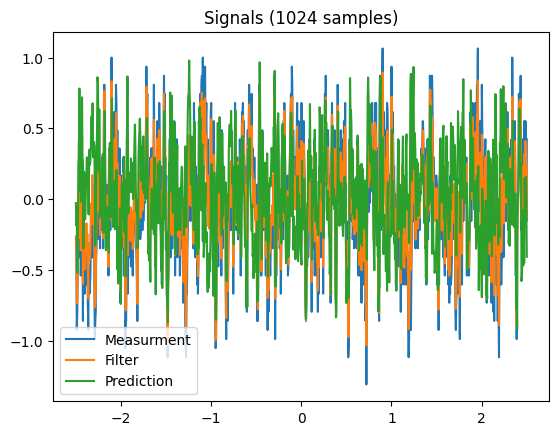

MSE for filterPy and matrices implementaion: 1.8027392333966112e-22, total of 1024 samples.


In [8]:
#filterPy implementaiton
s = kalman_filterPy(paperParams,zs_recorded)
data_x = s.x
data_z = s.z
data_x_prior = s.x_prior
data_K = s.K
# matrices implementation
data_m_x, data_m_z = matrices_implementation(paperParams,zs_recorded)

# choose part of the data to analyze
start_sample = 0 
end_sample = len(df["TIME ms"])
time_axis = df["TIME ms"][start_sample:end_sample]
data_x = data_x[start_sample:end_sample]
data_z = data_z[start_sample:end_sample]
data_x_prior = data_x_prior[start_sample:end_sample]
data_K = data_K[start_sample:end_sample]

data_m_x = data_m_x[start_sample:end_sample]
data_m_z = data_m_z[start_sample:end_sample]


# plot data
plt.plot(time_axis,data_z,label="Measurment")
plt.plot(time_axis,data_x[:, 0],label="Filter")
plt.plot(time_axis,data_x_prior[:,0],label="Prediction")
plt.title("Signals (" + str(len(time_axis)) + " samples)")
plt.legend()
plt.show()

mse = np.mean((data_m_x- data_x) ** 2)
print("MSE for filterPy and matrices implementaion: " + str(mse) + ", total of " + str(len(time_axis)) + " samples.")

### K gain histogram

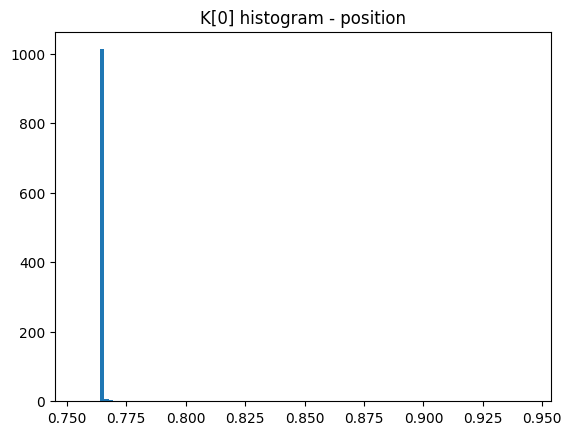

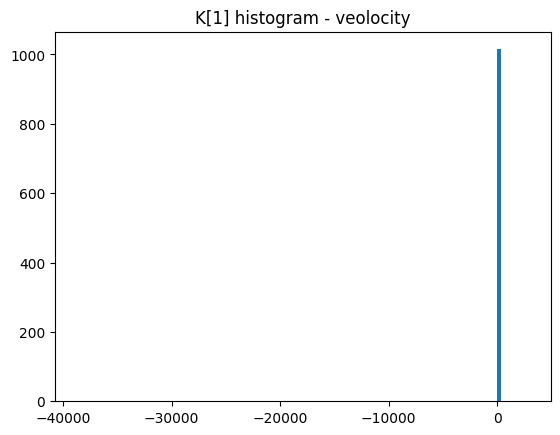

In [9]:

plt.hist(data_K[:,0],bins=100)
plt.title("K[0] histogram - position")
plt.show()

plt.hist(data_K[:,1],bins=100)
plt.title("K[1] histogram - veolocity")
plt.show()

In [10]:
### K gain over time

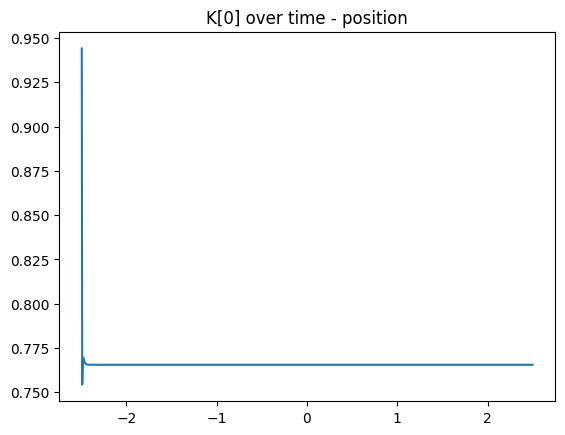

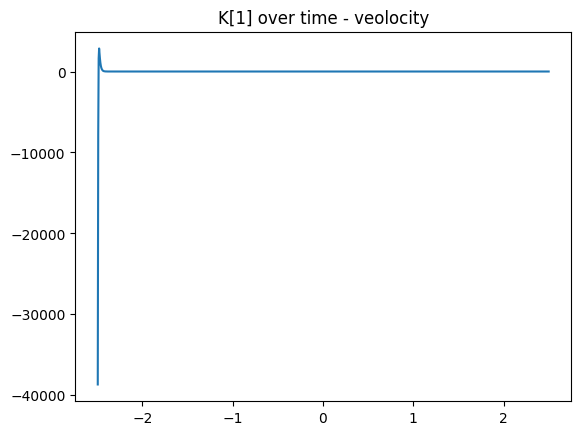

In [11]:
plt.plot(time_axis,data_K[:,0])
plt.title("K[0] over time - position")
plt.show()

plt.plot(time_axis,data_K[:,1])
plt.title("K[1] over time - veolocity")
plt.show()

### power spectrum

2025-03-27 22:32:36,175 - INFO - Sampling frequency (fs): 204804.80 Hz
2025-03-27 22:32:36,176 - INFO - Welch's method window size (nperseg): 256
2025-03-27 22:32:36,177 - INFO - Top 3 max power spectral values for measurment:
2025-03-27 22:32:36,177 - INFO -   1. Frequency: 2400.06 Hz, Power: 0.000026
2025-03-27 22:32:36,177 - INFO -   2. Frequency: 1600.04 Hz, Power: 0.000024
2025-03-27 22:32:36,177 - INFO -   3. Frequency: 15200.36 Hz, Power: 0.000013
2025-03-27 22:32:36,178 - INFO - Top 3 max power spectral values for filter:
2025-03-27 22:32:36,178 - INFO -   1. Frequency: 15200.36 Hz, Power: 0.000013
2025-03-27 22:32:36,178 - INFO -   2. Frequency: 2400.06 Hz, Power: 0.000012
2025-03-27 22:32:36,178 - INFO -   3. Frequency: 1600.04 Hz, Power: 0.000011
2025-03-27 22:32:36,178 - INFO - Top 3 max power spectral values for prediction:
2025-03-27 22:32:36,179 - INFO -   1. Frequency: 15200.36 Hz, Power: 0.000013
2025-03-27 22:32:36,179 - INFO -   2. Frequency: 2400.06 Hz, Power: 0.000

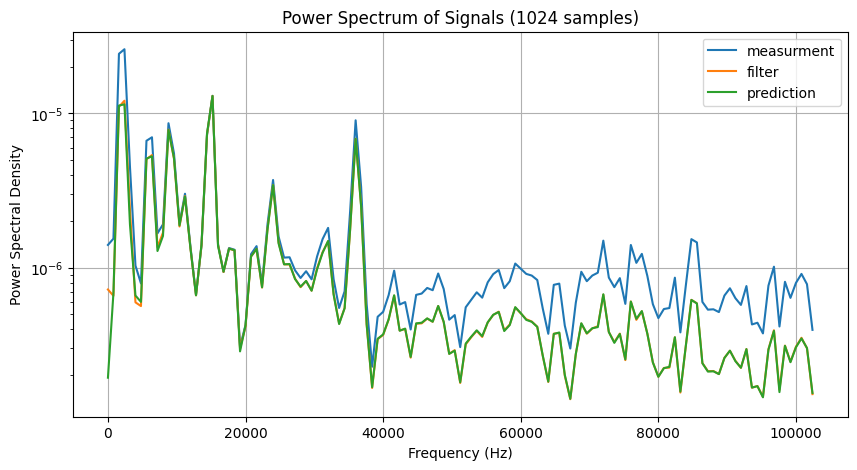

In [12]:
import numpy as np
import scipy.signal
import logging



# Configure logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

signals = {
    "measurment": data_z.flatten(),
    "filter": data_x[:, 0].flatten(),
    "prediction": data_x_prior[:,0].flatten()
}

# Define parameters
time_diff = np.mean(np.diff(time_axis))  # Calculate time step
fs = 1 / (time_diff * 1e-3)  # Convert ms to seconds
nperseg = 256  # Window segment size for Welch's method

# Log the parameters used
logging.info(f"Sampling frequency (fs): {fs:.2f} Hz")
logging.info(f"Welch's method window size (nperseg): {nperseg}")
# Function to log the top three maximum values in the power spectrum
def log_top_max(signal, frequencies, power_spectrum,num_of_max):
    # Find indices of the top three maximum values
    top_indices = np.argsort(power_spectrum)[-num_of_max:][::-1]  # Get indices of top 3 in descending order
    top_freqs = frequencies[top_indices]  # Corresponding frequencies
    top_values = power_spectrum[top_indices]  # Corresponding PSD values

    # Log the results
    logging.info(f"Top 3 max power spectral values for {signal}:")
    for i in range(num_of_max):
        logging.info(f"  {i+1}. Frequency: {top_freqs[i]:.2f} Hz, Power: {top_values[i]:.6f}")



# Compute power spectrum for each signal
power_spectrum_results = {}
frequencies = None


    

for signal_name, signal_arr in signals.items():
    freqs, psd = scipy.signal.welch(signal_arr, fs=fs, nperseg=nperseg)
    power_spectrum_results[signal_name] = psd   # Add small offset to avoid log(0)
    if frequencies is None:
        frequencies = freqs

# Log the top three peaks for each signal
for signal_name, signal_arr in signals.items():
    log_top_max(signal_name, frequencies, power_spectrum_results[signal_name],3)
    
# Plot power spectra
plt.figure(figsize=(10, 5))

for signal_name, signal_arr in signals.items():
    plt.semilogy(frequencies, power_spectrum_results[signal_name], label=signal_name)

# Labels and title
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power Spectral Density")
plt.title("Power Spectrum of Signals (" + str(len(time_axis)) + " samples)")
plt.legend()
plt.grid()

# Show the plot
plt.show()